In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from numba import njit

from parameter_measurement import dflipflop_vec, counter_simulation_vec, rtof_d_measure, generate_clocks

In [2]:
c         = 299792458  # [m/s] speed of light
f_adc_clk = 1e8;       # [Hz], measurement clock freq
f_e       = 1.0e6;     # [Hz], emitted wave freq, left TX
r         = 4999;      # unitless, heterodyning factor
N         = 1;         # unitless, averaging factor for left TX

# (r+1)(n) çarpımı 15k

f_sim = 1e10 # [Hz]

t_sim, t_sim_stop, spatial_sim_resolution, s_sim, s_adc_clk_re = generate_clocks(c, f_e, N, r, f_sim, f_adc_clk)

d_min = c/(2*r*f_e);

print("sim stop time:",t_sim_stop, "s")
print("sim length   :",int(t_sim_stop/t_sim),"samples")
print("sim time res :", t_sim*(10**12), "ps")
print("sim tvec size:", s_sim.nbytes/(1024**3), "GB")
print("sim space res:", 100*spatial_sim_resolution, "cm")
print("")
print("d_min    :", d_min*100, "cm")
print("Nli d_min:", d_min*100/N, "cm")
print("rate     :", 2*f_e/(N*(r+1)), "Hz")

sim stop time: 0.002625 s
sim length   : 26250000 samples
sim time res : 100.0 ps
sim tvec size: 0.1955777406692505 GB
sim space res: 2.99792458 cm

d_min    : 2.9985242848569715 cm
Nli d_min: 2.9985242848569715 cm
rate     : 400.0 Hz


In [3]:
range_start = 1.02
range_stop  = 20.10
dp = np.linspace(range_start, range_stop, int((range_stop-range_start)/(100*spatial_sim_resolution))+1)
dp = (t_sim*c)*np.round(dp/(t_sim*c))
fp = dp/c

In [4]:
s_h = np.sin(2*np.pi* f_e*(r/(r+1))*s_sim - np.pi/32)>0;
s_e = np.sin(2*np.pi* f_e *s_sim - np.pi/32)>0;
s_gate = np.sin(2*np.pi* f_e*(1/(N*(r+1))) *s_sim - np.pi/32)>0;
s_gate = s_gate[s_adc_clk_re]

tx = np.sin(2*np.pi* f_e *s_sim[s_adc_clk_re] - np.pi/32);
tx = np.fft.fft(tx);
tx[0:int(tx.shape[0]/2)] = 0;
tx = np.fft.ifft(tx);

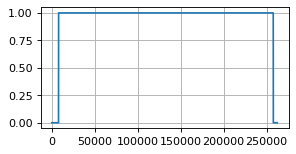

In [5]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=80)
ax.plot(s_gate)
ax.grid()
plt.show()

In [6]:
@njit(parallel=True, fastmath=True)
def s_r_zc(f, s_simulation, delay):
    return np.sin(2*np.pi*f*(s_simulation - 2*delay) - np.pi/32)>0;

@njit(parallel=True, fastmath=True)
def s_r_zc_noise(f, s_simulation, delay, n_stdev, noise):
    return (np.sin(2*np.pi*f*(s_simulation - 2*delay) - np.pi/32) + n_stdev*noise)>0;

@njit(parallel=True, fastmath=True)
def gen_noise(s_sim_shape):
    return np.random.randn(s_sim_shape);

@njit(parallel=True, fastmath=True)
def s_r_zc_justadd_noise(clean, n_stdev, noise):
    return (clean + n_stdev*noise)>0;

@njit(parallel=True, fastmath=True)
def rob_justadd_noise(clean, n_stdev, noise):
    return clean + n_stdev*noise;

In [7]:
snr_arr_db = np.linspace(-20,70,10);
stdev_arr  = (10**(-snr_arr_db/20))*2e-4 ; # 2e-5 from (-2*(f_e*0.95)*t_sim + 2*(f_e*1.05)*t_sim)/1 bandpass filter
print(stdev_arr)

[2.00000000e-03 6.32455532e-04 2.00000000e-04 6.32455532e-05
 2.00000000e-05 6.32455532e-06 2.00000000e-06 6.32455532e-07
 2.00000000e-07 6.32455532e-08]


In [8]:
iterations = 10;
d_act = fp*c
#d_bec = np.zeros((iterations, fp.shape[0]))

delay = fp[4]
clean = np.sin(2*np.pi*f_e*(s_sim - 2*delay) - np.pi/32)
d_bec = np.zeros((iterations, stdev_arr.shape[0]))
d_rob = np.zeros((iterations, stdev_arr.shape[0]))

for j in tqdm(range(0, iterations)):
    ns = gen_noise(s_sim.shape[0]);
#    for i in range(0, fp.shape[0]):
#        delay = fp[i]
    for i in range(0, stdev_arr.shape[0]):
        ### roberts
        rxr = sp.fft.fft(rob_justadd_noise(clean, stdev_arr[i], ns)[s_adc_clk_re]);
        rxr[0:int(rxr.shape[0]/2)] = 0;
        rxr = sp.fft.ifft(rxr);
        
        phase_shift_diff_est = np.mean(np.angle(tx * np.conjugate(rxr)));
        del rxr
        d_rob[j,i] = c*(phase_shift_diff_est/(2*np.pi*2*f_e))       
        
        ### becha
        #s_r  = s_r_zc(f_e, s_sim, delay)
        #s_r  = s_r_zc_noise(f_e, s_sim, delay, 0.01, ns)
        s_r = s_r_zc_justadd_noise(clean, stdev_arr[i], ns)
        s_eh = dflipflop_vec(s_e, s_h)[s_adc_clk_re]
        s_rh = dflipflop_vec(s_r, s_h)[s_adc_clk_re]
        del s_r
        s_phi    = np.logical_xor(s_eh, s_rh);
        s_phi_pp = s_phi*s_gate # clock applied implicitly with adc_clock_re

        count = counter_simulation_vec(s_phi_pp, s_gate)
        f_i = f_e/(r+1);
        phase_shift_est = 2*np.pi*(np.asarray(count)*f_i/(N*f_adc_clk))
        d_bec[j,i] = c*(phase_shift_est/(2*np.pi*2*f_e))

100%|██████████| 10/10 [00:42<00:00,  4.27s/it]


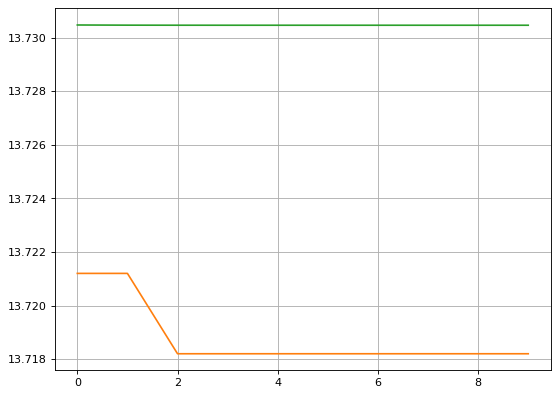

In [9]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
ax.plot(delay*c)
ax.plot(np.mean(d_bec,axis=0))
ax.plot(np.mean(-d_rob,axis=0))
ax.grid()
plt.show()

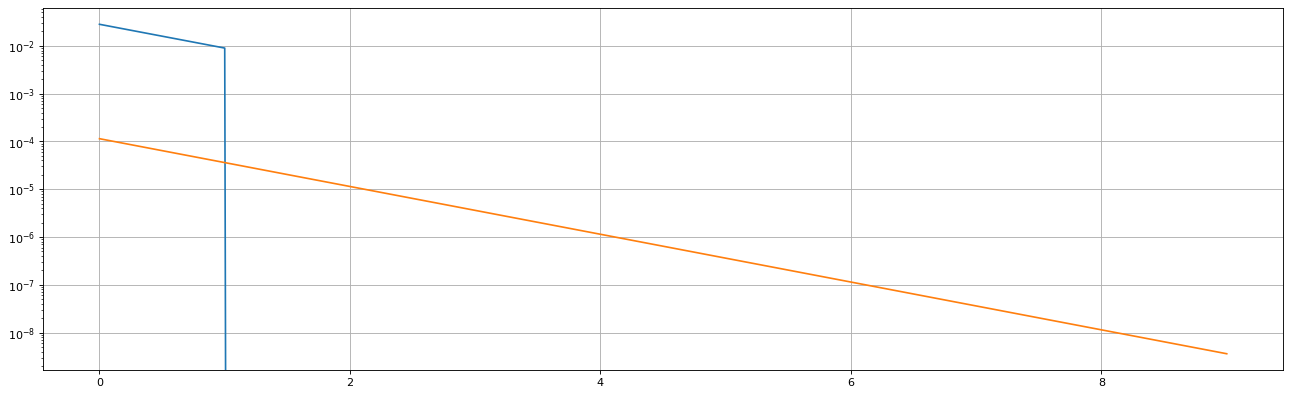

In [11]:
fig, ax = plt.subplots(figsize=(20, 6), dpi=80)
ax.semilogy(np.std(delay*c-d_bec,axis=0))
ax.semilogy(np.std(delay*c+d_rob,axis=0))
ax.grid()
#ax2 = ax.twinx()
#ax2.plot(np.mean(delay*c-d_bec,axis=0),'r')
#ax2.plot(np.mean(delay*c+d_rob,axis=0),'g')
plt.show()